[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train a YOLOv8 Oriented Bounding Boxes Model

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov8-obb-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics.

In this guide, we will walk through how to train a YOLOv8 oriented bounding box detection model.

If you notice that our notebook behaves incorrectly, let us know by [opening an issue on the Roboflow Notebooks repository](https://github.com/roboflow/notebooks/issues).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading our [YOLOv8 oriented bounding box training blog post](https://blog.roboflow.com/train-yolov8-obb-model/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Checking that our Colab environment has a GPU
- Installing YOLOv8
- Preparing a dataset
- Training a YOLOv8 OBB model
- Running inference on our model

Without further ado, let's get started!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu Dec 11 20:01:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

To install YOL0v8, run the following command:

In [4]:
!pip install ultralytics==8.2.103 -q

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.2/112.6 GB disk)


Now, we can import YOLOv8 into our Notebook:

In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## Roboflow Universe

Need data for your project? Check out Roboflow Universe, a repository of open source computer vision datasets. You can export any dataset labeled for instance segmentation as a YOLOv8 Oriented Bounding Boxes dataset for use in training a YOLOv8 Oriented Bounding Boxes model.

[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Prepare a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let us show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Choose "Object Detection" as your project type.

<img src="https://media.roboflow.com/obb-tutorial/create.png" alt="Object detection selected on the Roboflow Create Project pop up" height="300" />

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<img src="https://media.roboflow.com/obb-tutorial/upload.png" alt="Uploading images to Roboflow" height="300" />

### Step 3: Label Data

If you only have images, you can label them with oriented bounding boxes in [Roboflow Annotate](https://docs.roboflow.com/annotate).

**To label an oriented bounding box, use our polygon annotation tool.**

You can also take an existing segmentation dataset from your workspace or Roboflow Universe and export it as OBB.

<img src="https://media.roboflow.com/obb-tutorial/annotate.png" alt="Annotate an image" height="300" />

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<img src="https://media.roboflow.com/keypoint/version.png" alt="Generate a dataset version" height="300" />

### Step 5: Export dataset

Once the dataset version is generated, we can download it for use in training a model.

![Generate a dataset version](https://media.roboflow.com/keypoint/export.png)


In [4]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet



from roboflow import Roboflow
rf = Roboflow(api_key="0ZVz2FVfjuJHy2K22kJn")
project = rf.workspace("amal-tp-ulcd9").project("vehicle-dynamics")
version = project.version(2)
dataset = version.download("yolov8-obb")


/content/{HOME}/datasets
loading Roboflow workspace...
loading Roboflow project...


In [5]:
import yaml

with open(f'{dataset.location}/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
data['train'] = '../train/images'
data['val'] = '../valid/images'
data['test'] = '../test/images'
if 'path' in data:
  del data['path']
with open(f'{dataset.location}/data.yaml', 'w') as f:
    yaml.dump(data, f, sort_keys=False)

## Train a YOLOv8 OBB Object Detection Model

With our dataset downloaded, we can now train a YOLOv8 OBB object detection model. Run the code snippet below to start training your model:

In [1]:
# Uninstall numpy and ultralytics to ensure a clean slate
!pip uninstall numpy -y
!pip uninstall ultralytics -y

# Reinstall numpy and ultralytics to ensure compatibility and availability
#!pip install numpy # Allow pip to install a compatible, modern numpy version
#!pip install ultralytics==8.2.103 -q --force-reinstall

!pip install numpy==2.1.0
!pip install ultralytics


from ultralytics import YOLO

model = YOLO('yolov8n-obb.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

Found existing installation: numpy 2.3.5
Uninstalling numpy-2.3.5:
  Successfully uninstalled numpy-2.3.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.0 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00


KeyboardInterrupt: 

In [ ]:
# ========================
#  CLEAN INSTALLATION
# ========================

# Uninstall conflicting packages
!pip uninstall -y numpy ultralytics numba

# Install compatible numpy version
!pip install numpy==2.1.0

# Install ultralytics latest stable version
!pip install ultralytics

# Restart runtime to avoid "previously imported" warnings
import os
os._exit(0)


Found existing installation: numpy 2.1.0
Uninstalling numpy-2.1.0:
  Successfully uninstalled numpy-2.1.0
Found existing installation: ultralytics 8.3.236
Uninstalling ultralytics-8.3.236:
  Successfully uninstalled ultralytics-8.3.236
  Using cached numpy-2.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numba>=0.54; python_version < "3.14", which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
segregation 2.5.3 requires numba, which is not installed.
stumpy 1.13.0 requires numba>=0.57.1, which is not installed.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, which is not installed.
quantecon 0.10.1 requires numba>=0.49.0, which is 

  Using cached ultralytics-8.3.236-py3-none-any.whl.metadata (37 kB)
Using cached ultralytics-8.3.236-py3-none-any.whl (1.1 MB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python

In [6]:
!pip install ultralytics
from ultralytics import YOLO

# Load OBB pre-trained model
model = YOLO("yolov8n-obb.pt")

# Train
results = model.train(
    data="/content/{HOME}/datasets/Vehicle-dynamics-2/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,           # use GPU if available
    pretrained=True,
    workers=2
)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/{HOME}/datasets/Vehicle-dynamics-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

Your model will train for 100 epochs. After training, you can run test your model using an image from your test set.

## Test the OBB Object Detection Model

Let's test our OBB detection model on an image:

In [7]:
model = YOLO('runs/obb/train/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

print(results[0])


image 1/1 /content/{HOME}/datasets/Vehicle-dynamics-2/test/images/frame_000067_png.rf.7010ee820628f17a556ca533bd4a5920.jpg: 640x640 1 my_car, 12.4ms
Speed: 3.8ms preprocess, 12.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'my_car'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[151, 146, 147],
        [147, 142, 143],
        [144, 142, 142],
        ...,
        [ 91, 101, 101],
        [ 83,  95,  95],
        [ 87,  99,  99]],

       [[131, 129, 129],
        [115, 113, 112],
        [132, 130, 130],
        ...,
        [ 96, 106, 106],
        [ 87,  99,  99],
        [ 90, 102, 102]],

       [[123, 124, 122],
        [113, 114, 110],
        [114, 115, 113],
        ...,
        [104, 114, 114],
        [ 92, 104, 104],
        [ 91, 103, 103]],

       ...,

       [[126, 128, 128],
        [132, 134, 134],
        [140, 142, 14

We can visualize our oriented bounding box predictions using the following code:

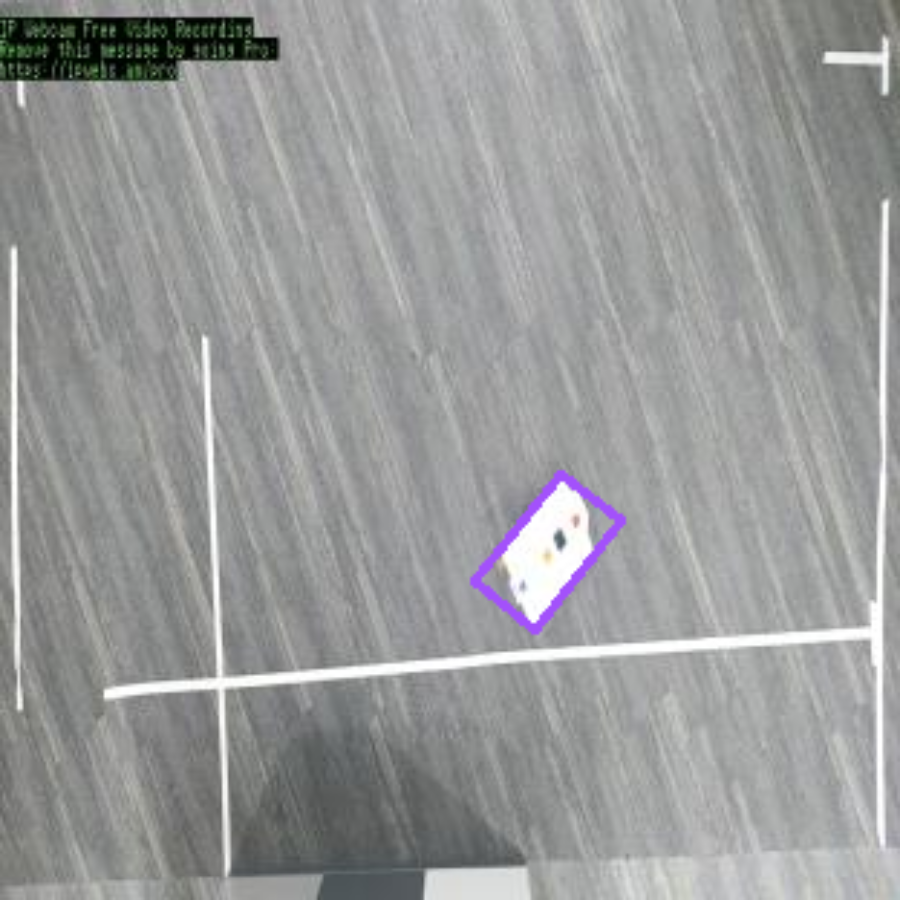

In [10]:
!pip install supervision==0.24.0 -q

import supervision as sv
import cv2

detections = sv.Detections.from_ultralytics(results[0])

oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=cv2.imread(file_name),
    detections=detections
)

annotated_frame = sv.resize_image(
    annotated_frame,
    resolution_wh=(900, 900),
    keep_aspect_ratio=True
)
sv.cv2_to_pillow(annotated_frame)

Our model successfully identified the location of solar panels in the image. All solar panels have an oriented bounding box that fit the panel closely.

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.